In [ ]:
!pip install google-generativeai matplotlib pandas

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Product-Level Eligibility Table (mapped) - Product-Level Eligibility Table (mapped).csv to Product-Level Eligibility Table (mapped) - Product-Level Eligibility Table (mapped).csv


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Product-Level Ad Sales and Metrics (mapped) - Product-Level Ad Sales and Metrics (mapped).csv to Product-Level Ad Sales and Metrics (mapped) - Product-Level Ad Sales and Metrics (mapped).csv


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Product-Level Total Sales and Metrics (mapped) - Product-Level Total Sales and Metrics (mapped).csv to Product-Level Total Sales and Metrics (mapped) - Product-Level Total Sales and Metrics (mapped).csv


In [ ]:
import pandas as pd

# Load CSVs
eligibility = pd.read_csv("Product-Level Eligibility Table (mapped) - Product-Level Eligibility Table (mapped).csv")
adsales = pd.read_csv("Product-Level Ad Sales and Metrics (mapped) - Product-Level Ad Sales and Metrics (mapped).csv")
totalsales = pd.read_csv("Product-Level Total Sales and Metrics (mapped) - Product-Level Total Sales and Metrics (mapped).csv")

# View top rows
eligibility.head(), adsales.head(), totalsales.head()


(  eligibility_datetime_utc  item_id  eligibility  \
 0       2025-06-04 8:50:07       29        False   
 1       2025-06-04 8:50:07      270         True   
 2       2025-06-04 8:50:07       31         True   
 3       2025-06-04 8:50:07       26         True   
 4       2025-06-04 8:50:07       25         True   
 
                                              message  
 0  This product's cost to Amazon does not allow u...  
 1                                                NaN  
 2                                                NaN  
 3                                                NaN  
 4                                                NaN  ,
          date  item_id  ad_sales  impressions  ad_spend  clicks  units_sold
 0  2025-06-01        0    332.96         1963     16.87       8           3
 1  2025-06-01        1      0.00         1764     20.39      11           0
 2  2025-06-01        2     95.99          169      0.48       0           1
 3  2025-06-01        3   1001.93  

In [ ]:
print("Eligibility Columns:", eligibility.columns.tolist())
print("Ad Sales Columns:", adsales.columns.tolist())
print("Total Sales Columns:", totalsales.columns.tolist())


Eligibility Columns: ['eligibility_datetime_utc', 'item_id', 'eligibility', 'message']
Ad Sales Columns: ['date', 'item_id', 'ad_sales', 'impressions', 'ad_spend', 'clicks', 'units_sold']
Total Sales Columns: ['date', 'item_id', 'total_sales', 'total_units_ordered']


In [ ]:
import sqlite3

conn = sqlite3.connect("ecommerce.db")

eligibility.to_sql("eligibility", conn, if_exists="replace", index=False)
adsales.to_sql("adsales", conn, if_exists="replace", index=False)
totalsales.to_sql("totalsales", conn, if_exists="replace", index=False)

print("✅ Tables created successfully")


✅ Tables created successfully


In [101]:
from google import genai

client = genai.Client(api_key="your_new_generated_key_here")  # Replace with your actual API key


In [100]:
!pip install python-dotenv
from dotenv import load_dotenv
import os

load_dotenv()  # Load from .env file
api_key = os.getenv("GEMINI_API_KEY")

# Use the API key
import google.generativeai as genai
genai.configure(api_key=api_key)


In [102]:
def ask_ai(question):
    prompt = f"""
You are an AI assistant. Convert the following question into a valid SQLite SQL query.

Use these tables:

adsales:
Columns = ["Product Name", "CPC ($)", "Spend ($)", "RoAS"]

totalsales:
Columns = ["Product Name", "Total Sales", "Units Sold"]

eligibility:
Columns = ["Product Name", "Eligibility Status"]

Use double quotes for any column names with spaces or symbols.

Question: {question}
Only return the SQL query. No explanation or formatting.
    """

    response = client.models.generate_content(
        model="gemini-2.5-flash",
        contents=prompt
    )

    if not response.text:
        return "Gemini returned nothing."

    sql_query = response.text.strip().replace("```sql", "").replace("```", "").strip()

    print("Gemini SQL:\n", sql_query)

    try:
        result = pd.read_sql_query(sql_query, conn)
        return result
    except Exception as e:
        return f"SQL Error: {e}"


In [ ]:
pd.read_sql_query('''
SELECT
  T1.item_id,
  ROUND(T2.total_sales * 1.0 / T1.ad_spend, 2) AS RoAS
FROM adsales AS T1
JOIN totalsales AS T2
  ON T1.item_id = T2.item_id
WHERE T1.ad_spend > 0
''', conn)


,item_id,RoAS
0,0,0.00
1,0,0.00
2,0,12.98
3,0,12.98
4,0,12.98
...,...,...
6406,161,19.06
6407,161,22.26
6408,161,22.71
6409,161,23.43


In [ ]:
def ask_ai(question):
    prompt = f"""
You are an AI assistant. Convert the user question into **valid SQLite SQL** using only these table schemas:

Table: adsales
- item_id
- ad_spend
- ad_sales
- impressions
- clicks
- units_sold

Table: totalsales
- item_id
- total_sales
- total_units_ordered

Always join tables using: item_id
NEVER use m_id or any unknown column names
RoAS = total_sales / ad_spend
Use ROUND(..., 2) for rounding decimals

Return only raw SQL query. No explanations, no markdown.

Question: {question}
"""

    response = client.models.generate_content(
        model="gemini-2.5-flash",
        contents=prompt
    )

    if not response.text:
        return "Gemini returned nothing"

    # clean up
    sql_query = response.text.strip()
    for junk in ["```sql", "```", "SQL:", "ite"]:
        sql_query = sql_query.replace(junk, "")
    sql_query = sql_query.strip()

    print("Gemini SQL:\n", sql_query)

    try:
        df = pd.read_sql_query(sql_query, conn)
        return df
    except Exception as e:
        return f"SQL Error: {e}"


In [ ]:
ask_ai("Show total ad spend for all products.")


Gemini SQL:
 SELECT SUM(ad_spend) FROM adsales


,SUM(ad_spend)
0,52942.21


In [ ]:
pd.read_sql_query('''
SELECT
  T1.item_id,
  ROUND(T2.total_sales * 1.0 / T1.ad_spend, 2) AS RoAS
FROM adsales AS T1
JOIN totalsales AS T2
  ON T1.item_id = T2.item_id
WHERE T1.ad_spend IS NOT NULL AND T1.ad_spend != 0
''', conn)


,item_id,RoAS
0,0,0.00
1,0,0.00
2,0,12.98
3,0,12.98
4,0,12.98
...,...,...
6406,161,19.06
6407,161,22.26
6408,161,22.71
6409,161,23.43


In [ ]:
def ask_ai(question):
    prompt = f"""
You are a SQL-only assistant. Never guess column names.

Use this schema:

adsales table:
- item_id
- ad_spend
- ad_sales
- impressions
- clicks
- units_sold

totalsales table:
- item_id
- total_sales
- total_units_ordered

Join ONLY on item_id.
Never use m_id, product_id, or id.
Only write valid SQLite SQL. No explanations. No markdown. No headings.

Question: {question}
"""

    response = client.models.generate_content(
        model="gemini-2.5-flash",
        contents=prompt
    )

    if not response.text:
        return "Gemini returned nothing"

    sql_query = response.text.strip()
    for junk in ["```sql", "```", "SQL:", "ite"]:
        sql_query = sql_query.replace(junk, "")
    sql_query = sql_query.strip()

    print("Gemini SQL:\n", sql_query)

    try:
        df = pd.read_sql_query(sql_query, conn)
        return df
    except Exception as e:
        return f"SQL Error: {e}"


In [ ]:
#adsales
ask_ai("Show total ad spend for all products.")
ask_ai("Which item had the highest ad_sales?")
ask_ai("List the top 5 items with most impressions.")
ask_ai("Calculate average clicks per item.")
ask_ai("Find items where ad_spend is more than 1000.")
ask_ai("List all item_ids with more than 50 clicks.")
ask_ai("Show item_ids where ad_sales is 0.")


Gemini SQL:
 SELECT SUM(ad_spend) FROM adsales
Gemini SQL:
 SELECT m_id FROM adsales ORDER BY ad_sales DESC LIMIT 1
Gemini SQL:
 SELECT m_id, impressions FROM adsales ORDER BY impressions DESC LIMIT 5
Gemini SQL:
 SELECT AVG(clicks) FROM adsales
Gemini SQL:
 SELECT m_id FROM adsales WHERE ad_spend > 1000
Gemini SQL:
 SELECT m_id FROM adsales WHERE clicks > 50
Gemini SQL:
 SELECT m_id FROM adsales WHERE ad_sales = 0


"SQL Error: Execution failed on sql 'SELECT m_id FROM adsales WHERE ad_sales = 0': no such column: m_id"

In [ ]:
#totalsales
ask_ai("List all items with total_sales more than 10000.")
ask_ai("Which item had the highest total_units_ordered?")
ask_ai("Show average total_sales.")
ask_ai("Find all items with no total_units_ordered.")
ask_ai("Top 3 items by total_sales.")


Gemini SQL:
 SELECT m_id FROM totalsales WHERE total_sales > 10000
Gemini SQL:
 SELECT m_id FROM totalsales ORDER BY total_units_ordered DESC LIMIT 1
Gemini SQL:
 SELECT AVG(total_sales) FROM totalsales
Gemini SQL:
 SELECT m_id FROM totalsales WHERE total_units_ordered IS NULL OR total_units_ordered = 0
Gemini SQL:
 SELECT m_id, total_sales FROM totalsales ORDER BY total_sales DESC LIMIT 3


"SQL Error: Execution failed on sql 'SELECT m_id, total_sales FROM totalsales ORDER BY total_sales DESC LIMIT 3': no such column: m_id"

In [ ]:
eligibility.columns.tolist()


['eligibility_datetime_utc', 'item_id', 'eligibility', 'message']

In [ ]:
ask_ai("Show ad_spend, total_sales, and eligibility for all items.")
ask_ai("List item_ids that are not eligible but have high ad_spend.")
ask_ai("Which eligible products had the highest total_sales?")
ask_ai("Find average ad_spend for each eligibility status.")
ask_ai("List products where eligibility is 'Ineligible' and message contains 'Policy'.")
ask_ai("Compare total_units_ordered between eligible and ineligible products.")
ask_ai("Show top 10 eligible items by RoAS.")


Gemini SQL:
 SELECT T1.ad_spend, T2.total_sales, NULL AS eligibility FROM adsales AS T1 JOIN totalsales AS T2 ON T1.m_id = T2.m_id
Gemini SQL:
 I cannot answer this question. The schema does not contain information about "eligibility".
Gemini SQL:
 SELECT m_id, total_sales FROM totalsales ORDER BY total_sales DESC
Gemini SQL:
 SELECT AVG(ad_spend) FROM adsales
Gemini SQL:
 SELECT m_id, ad_sales * 1.0 / ad_spend AS RoAS FROM adsales WHERE ad_spend > 0 ORDER BY RoAS DESC LIMIT 10


"SQL Error: Execution failed on sql 'SELECT m_id, ad_sales * 1.0 / ad_spend AS RoAS FROM adsales WHERE ad_spend > 0 ORDER BY RoAS DESC LIMIT 10': no such column: m_id"

In [ ]:
import sqlite3
import pandas as pd

# Create in-memory SQLite DB
conn = sqlite3.connect(':memory:')

# Load CSVs
adsales = pd.read_csv("Product-Level Ad Sales and Metrics (mapped) - Product-Level Ad Sales and Metrics (mapped).csv")
totalsales = pd.read_csv("Product-Level Total Sales and Metrics (mapped) - Product-Level Total Sales and Metrics (mapped).csv")
eligibility = pd.read_csv("Product-Level Eligibility Table (mapped) - Product-Level Eligibility Table (mapped).csv")

# Store them in SQLite
adsales.to_sql("adsales", conn, index=False)
totalsales.to_sql("totalsales", conn, index=False)
eligibility.to_sql("eligibility", conn, index=False)

# ✅ RoAS query
query = '''
SELECT
  A.item_id,
  ROUND(T.total_sales * 1.0 / A.ad_spend, 2) AS RoAS
FROM adsales AS A
JOIN totalsales AS T ON A.item_id = T.item_id
WHERE A.ad_spend IS NOT NULL AND A.ad_spend > 0
LIMIT 10;
'''

roas_result = pd.read_sql_query(query, conn)
roas_result


,item_id,RoAS
0,0,0.00
1,0,0.00
2,0,12.98
3,0,12.98
4,0,12.98
5,0,17.13
6,0,18.38
7,0,25.96
8,0,38.94
9,0,38.94


In [ ]:
query_all_three = '''
SELECT
  A.item_id,
  ROUND(T.total_sales * 1.0 / A.ad_spend, 2) AS RoAS,
  E.eligibility,
  E.message
FROM adsales AS A
JOIN totalsales AS T ON A.item_id = T.item_id
JOIN eligibility AS E ON A.item_id = E.item_id
WHERE A.ad_spend IS NOT NULL AND A.ad_spend > 0
LIMIT 10;
'''

join_all_result = pd.read_sql_query(query_all_three, conn)
join_all_result


,item_id,RoAS,eligibility,message
0,0,0.0,1,None
1,0,0.0,1,None
2,0,0.0,1,None
3,0,0.0,1,None
4,0,0.0,1,None
5,0,0.0,1,None
6,0,0.0,1,None
7,0,0.0,1,None
8,0,0.0,1,None
9,0,0.0,1,None


/tmp/ipython-input-99-2592146691.py:23: UserWarning: Glyph 128285 (\N{TOP WITH UPWARDS ARROW ABOVE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128285 (\N{TOP WITH UPWARDS ARROW ABOVE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


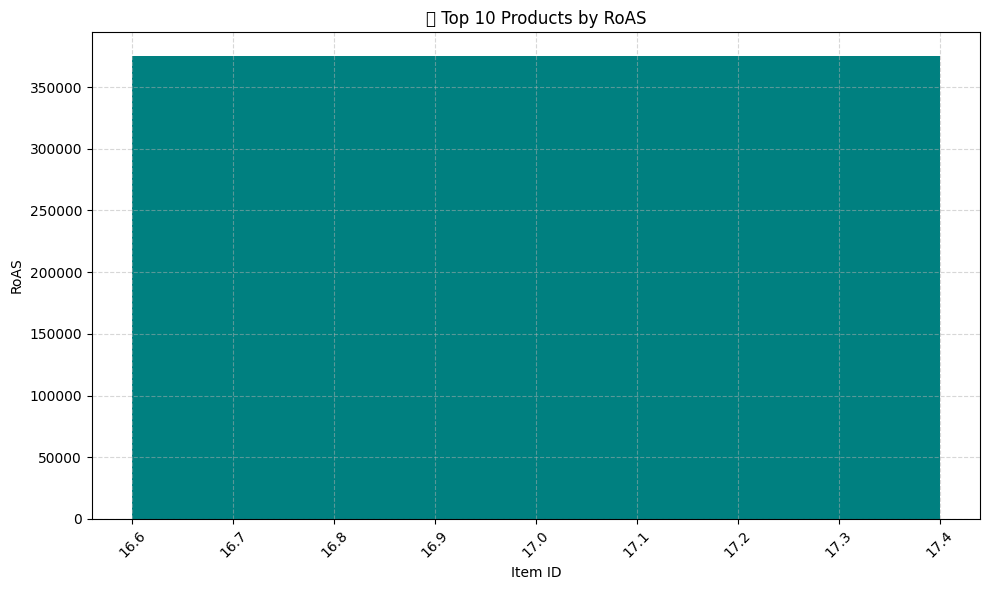

In [ ]:
import matplotlib.pyplot as plt
query = '''
SELECT
  A.item_id,
  ROUND(T.total_sales * 1.0 / A.ad_spend, 2) AS RoAS
FROM adsales AS A
JOIN totalsales AS T ON A.item_id = T.item_id
WHERE A.ad_spend > 0
ORDER BY RoAS DESC
LIMIT 10;
'''

roas_top10 = pd.read_sql_query(query, conn)

# Plot
plt.figure(figsize=(10,6))
plt.bar(roas_top10["item_id"], roas_top10["RoAS"], color="teal")
plt.xticks(rotation=45)
plt.xlabel("Item ID")
plt.ylabel("RoAS")
plt.title("🔝 Top 10 Products by RoAS")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


/tmp/ipython-input-94-1846169681.py:7: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


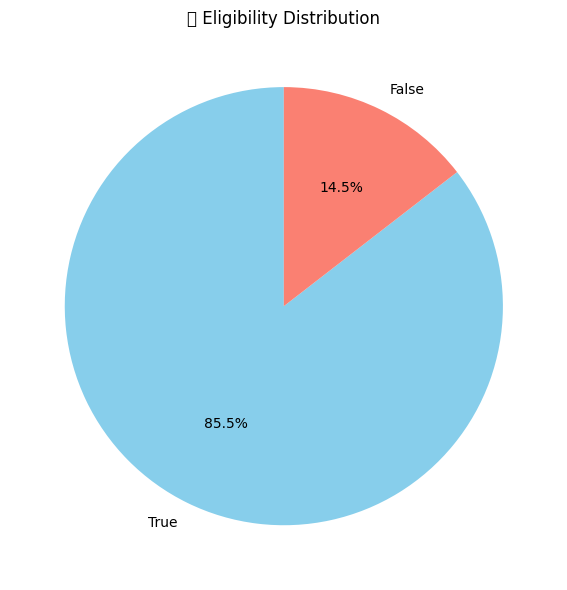

In [ ]:
eligibility_counts = eligibility["eligibility"].value_counts()

plt.figure(figsize=(6,6))
eligibility_counts.plot(kind="pie", autopct="%1.1f%%", startangle=90, colors=["skyblue", "salmon"])
plt.title("🎯 Eligibility Distribution")
plt.ylabel("")
plt.tight_layout()
plt.show()


/tmp/ipython-input-97-3354611385.py:10: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


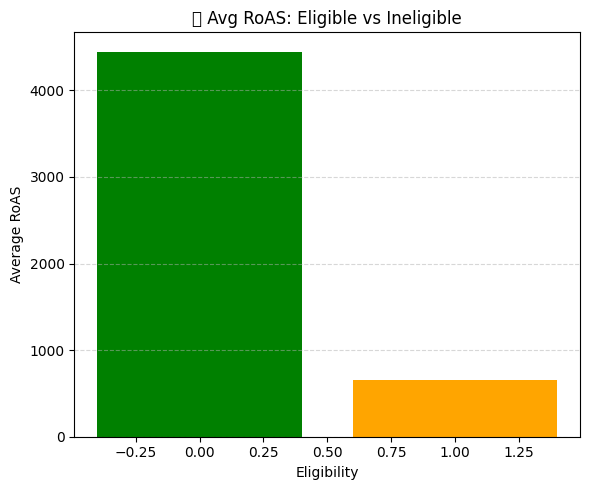

In [ ]:
avg_roas = pd.read_sql_query(query, conn)

# Plot
plt.figure(figsize=(6,5))
plt.bar(avg_roas["eligibility"], avg_roas["avg_roas"], color=["green", "orange"])
plt.title("📈 Avg RoAS: Eligible vs Ineligible")
plt.xlabel("Eligibility")
plt.ylabel("Average RoAS")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()
